# Book Recommender System: Matrix Factorization via Singular Value Decomposition

Angel Wang

07/18/2021

BrainStation - Capstone Project 

# Introduction

## Background

Nowadays services like Netflix, Youtube, and Amazon knows our preferences - they use very well-designed systems to recommend tailored items targeting each individual. 

There are two types of commonly used approaches:

* Content-based filtering system
* Collaborative filtering system

**Content-based filtering system**

Content-base filtering system tries to conclude the features of items that each user reacts positively to. For example, the genre of books, the starring of movies, etc. 

During recommendation, the similarity metrics are calculated from the item's feature vectors and the user's preferred feature vectors from historical records. The top items are then recommended.

Content-based filtering doesn't require other users' data when making recommendations to one user.

**Collaborative filtering system**

Collaborative filtering system doesn't need any demographic data for the user or the item. Every user and item is described by a feature vector or embedding.

It vectorize each user by their feedback on various items, find the users that have similar taste, and recommend items that people behave like you would like. 

The user feedbacks usually come from two sources:
* Implicit Feedback: the user's likes and dislikes are noted and recorded on actions like clicks, searches, and purchases.
* Explicit Feedback: the user articulate likes and dislikes by reacting or rating the items.



There are 2 main types of collaborative recommender systems:

**Memory-based collaborative filtering**

Done mainly remembering the user_item interaction matrix, and how a user reacts to it. There's no dimensionality reduction or model fitting as such.

* **User-user filtering**: if user A's characteristics are similar to user B, then the products B liked are recommended to A.
> "People who like products similar to you also liked these..."

* **Item-item filtering**: if user A likes item X, then items Y and Z which are similar to X in property will be recommended to user A. "
> Because you liked this, you may also like those..."

**Model-based collaborative filtering**

From the matrix, how a specific user or an item behaves is learned. The large interaction matrix is compressed and machine learning models are fit to predict potential ratings.

* **Clustering algorithms**: use simple clustering algorithms like KNN to find the K nearest neighbors given a user or an item based on the similarity metrics used.

* **Matrix Factorization based algorithm**: the interaction matrix can be factorized into two smaller matrices, and they can be used to generate back the interaction matrix to predict the unknown values. 

* **Deep Learning methods**: to learn a non-linear function rather than a linear one and in doing so hopefully increase the expressiveness of the final model.

## This Project

This project builds a book recommender system using Matrix Factorization in Collaborative filtering, with Singular Value Decomposition for dimensionality reduction. The details of this algorithm will be explained in following sections. 

The training data is collected from www.goodreads.com. The analytical steps include EDA, visualization, data cleaning, building the model using `surprise` package, calculate errors and compare with the base rate, single and multiple hyperparameter tuning, and model evaluation.

The recommender system can predict which books users might enjoy reading based on their past ratings. It can also make recommendations for new users who haven't rated yet.

The purpose of this project is to help readers find books that might make a positive impact on them, and to encourage people spend more time reading.

# Source of Data

## Description

The data used in this project were collected in late 2017 from www.goodreads.com. All data was scraped from users' public shelves, which means everyone can see these information on web without login. User IDs and review IDs are anonymized.

There are 3 groups of data collected:

* **meta-data of the books**: detailed meta-data of books, including title, isbn, publisher, popular shelves, etc; records on authors, works, series.

* **user-book interactions**: including review records with user id, book id, review id, rating, timestamps, etc.

* **user's detailed book reviews**: including the user id, book id, detailed review text, number of votes and comments, etc.

The datasets are downloaded from a public collection of recommender system datasets posted by the lab of Julian McAuley, UCSD: https://cseweb.ucsd.edu/~jmcauley/datasets.html#goodreads

## Data Selected

Since the full datasets contain 2,360,655 books and 876,145 users and add up to hundreds of GB, this project only uses 2 datasets from the `Poetry` genre to limit extensive calculation.

The datasets are in compressed `json` format.

**goodreads_books_young_adult.json.gz** (93,398 books)

https://drive.google.com/uc?id=1gH7dG4yQzZykTpbHYsrw2nFknjUm0Mol

**goodreads_interactions_young_adult.json.gz** (34,919,254 interactions)

https://drive.google.com/uc?id=1NNX7SWcKahezLFNyiW88QFPAqOAYP5qg

## Citation

Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in *RecSys'18*.

Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", *in ACL'19*.

# Preprocessing

## Import the data

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This notebook was written in Google Colab, and the datasets were directly imported from google drive links.

If you need help importing data into Google Colab, please visit: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

In [2]:
# set up the connection between this notebook and the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the datasets
Interactions = pd.read_json('/content/drive/MyDrive/BrainStation Capstone/goodreads_interactions_poetry.json.gz', lines = True)
Books = pd.read_json('/content/drive/MyDrive/BrainStation Capstone/goodreads_books_poetry.json.gz', lines=True)

If you need to run the notebook from a local machine, please download the datasets to the same directory as this notebook, and uncomment and run the next cell.

In [ ]:
# Interactions = pd.read_json('goodreads_interactions_poetry.json.gz', lines = True)
# Books = pd.read_json('goodreads_books_poetry.json.gz', lines = True)

## Basic Examination

In this part we take a look at the loaded datasets, and check some basic features.

In [4]:
# shape of Interactions
print(f'Interactions have {Interactions.shape[0]} rows and {Interactions.shape[1]} columns')

Interactions have 2734350 rows and 10 columns


In [ ]:
# check the first interactions
Interactions.head(3)

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,


In [ ]:
# column names of Interactions
Interactions.columns

Index(['user_id', 'book_id', 'review_id', 'is_read', 'rating',
       'review_text_incomplete', 'date_added', 'date_updated', 'read_at',
       'started_at'],
      dtype='object')

In [ ]:
# shape of Books
print(f'Books have {Books.shape[0]} rows and {Books.shape[1]} columns')

Books have 36514 rows and 29 columns


In [ ]:
# check the first books
Books.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,[],Number 30 in a series of literary pamphlets pu...,Paperback,https://www.goodreads.com/book/show/16037549-v...,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80,1,,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,[],Fairy Tales gathers the unconventional verse d...,Paperback,https://www.goodreads.com/book/show/22466716-f...,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128,20,9780811223980,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,[],Three poems describe the nighttime adventures ...,Paperback,https://www.goodreads.com/book/show/926662.Gro...,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,,12,9780374428112,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems


In [ ]:
# column names of Books
Books.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

## EDA

The most relative distributions are the number of time each user rates, and the number of time each book is rated.

Usually, in a scenario like this, there's a small amount of users rate the most frequently, while the rest of them (also the majority) rarely rate. 

Similarly, the most ratings would concentrate on the most popular books, while the majority of the books don't get rated as much.

Before visualizing the distribution, let's create a function `find_pareto_pct` to help us find the exact percentage in this assumption.

*The Pareto Principle*

*80% of consequences come from 20% of the causes. The principle, which was derived from the imbalance of land ownership in Italy, is commonly used to illustrate the notion that not things are equal, and the minority owns the majority.*

In [5]:
# find the percentage of a certain variable that consist of the given percentage of rows
# e.g. find the percentage of the most active users that gave 70% of the ratings

def find_pareto_pct(df, var, row_name, var_name, pct = 80):

  '''
  Parameters
  ---
  df: the input dataframe
  var: the name of the column in interest, a string
  row_name: to plug into the print statement, indicating the meaning of each row, a string
  var_name: to plug into the print statement, indicating the meaning of var, a string
  pct: the percentage of rows interested

  Output
  ---  
  print statements describing the results
  top_vars_pct: the percentage of a certain variable that consist of the given percentage of rows, a number

  Example
  ---
  ratings_df
  +---------+--------+---------+-----------------+
  | user_id | rating |  title  |      link       |
  +---------+--------+---------+-----------------+
  |    1    |    5   | Sample1 | www.sample1.com |
  |    2    |    5   | Sample2 | www.sample2.com |
  |   ...   |   ...  |   ...   |      ...        |
  +---------+--------+---------+-----------------+
  >>>> find_pareto_pct(df = ratings_df, var = 'user_id, row_name = 'ratings', var_name = 'users', pct = 80)
  'The dataset contains 2734350 ratings in total, given by 377799 users.'
  '80% of the ratings (2187480) were given by the 30% most active users (112062).'
  30
  '''

  # assert the datatype of inputs
  assert isinstance(df, pd.DataFrame), 'df must be a pandas dataframe'
  assert isinstance(var, str), 'var must be a string'
  assert isinstance(row_name, str), 'row_name must be a string'
  assert isinstance(var_name, str), 'var_name must be a string'
  assert (isinstance(pct, (int, float))) & (0 < pct < 100), 'pct must be a number between 0 and 100'

  # Distribution of number of rows each value in var contributes
  num_rows_per_var = pd.DataFrame(df[var].value_counts())

  # rename the column
  num_rows_per_var.rename(columns = {var: 'counts'}, inplace = True)

  # calculate the cumulative sum of the counts
  num_rows_per_var['cum_sum'] = np.cumsum(num_rows_per_var['counts'])

  # reset index for consecutive row numbers
  num_rows_per_var.reset_index(inplace = True, drop = True)

  # calculations
  total_rows = df.shape[0]
  total_vars = num_rows_per_var.shape[0]
  top_rows = int(total_rows * pct / 100)
  top_vars = 0

  for i in range(total_vars):
   if num_rows_per_var.loc[i]['cum_sum'] >= top_rows:
     top_vars = i + 1
     break

  top_vars_pct = round(top_vars / total_vars * 100)

  # output
  print(f'The dataset contains {total_rows} {row_name} and {total_vars} {var_name} in total.')
  print(f'{pct}% of the {row_name} ({top_rows}) are contributed by {top_vars_pct}% of the most active {var_name} ({top_vars}).')
  
  return top_vars_pct

Now we can use this function to add on some insights!

### `user_id`

In [ ]:
find_pareto_pct(df = Interactions, var = 'user_id', row_name = 'ratings', var_name = 'users', pct = 70);

The dataset contains 2734350 ratings and 377799 users in total.
70% of the ratings (1914045) are contributed by 19% of the most active users (70947).


70% of the ratings are contributed by 19% of the most active users! Even if we visualize this distribution, it will not provide much detail since it will have an extremely long tail.

In [ ]:
# the number of time each user rates
user_num_ratings = Interactions['user_id'].value_counts()
user_num_ratings

446a78a97c434dca98e7ea176ee9fa1f    2924
adcae0c259fce6f216dd11bb973508fd    2906
55bea8421fbd1f96790bcaa6302b5aab    2444
f2bac05b3932fe7c68960041744e5058    2332
0d688fe079530ee1fe6fa85eab10ec5c    2128
                                    ... 
8ac7161c1afb960d7be3efcc8ff5c038       1
0741b44ddea8c92c2895ac4b6b3aa27d       1
147548f523e5be912d643fefd0975ca5       1
52e9e43df2c728be2c1e6054d3c2ff6c       1
ee6db2afc33a24b448377bd0c0c36105       1
Name: user_id, Length: 377799, dtype: int64

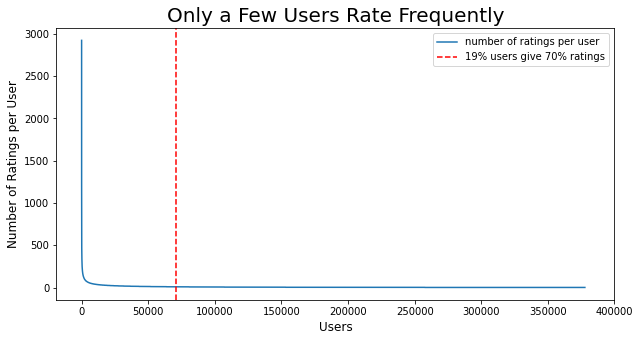

In [ ]:
# plot the number of time each user rates
plt.figure(figsize = (10, 5))
user_num_ratings.plot(label = 'number of ratings per user')
plt.xlabel('Users', fontsize = 12)
plt.ylabel('Number of Ratings per User', fontsize = 12)
plt.title('Only a Few Users Rate Frequently', fontsize = 20)
plt.xticks(ticks = range(0, 400001, 50000), labels = range(0, 400001, 50000))
plt.axvline(x = 70947, color = 'r', linestyle = '--', label = '19% users give 70% ratings') # number of 19% most active users from the print statement
plt.legend()
# plt.savefig('/content/drive/MyDrive/BrainStation Capstone/user_num_ratings.png', transparent = True)
plt.show()

### `book_id`

Are the books being rated similarly? Let's find out!

In [ ]:
find_pareto_pct(df = Interactions, var = 'book_id', row_name = 'ratings', var_name = 'books');

The dataset contains 2734350 ratings and 36514 books in total.
80% of the ratings (2187480) are contributed by 12% of the most active books (4315).


Even a smaller percentage is returned this time! Seems like readers tend to spend more time enjoy the classics instead of reading randomly.

In [ ]:
# the number of times each book is rated
book_num_ratings = Interactions['book_id'].value_counts()
book_num_ratings.reset_index(inplace = True, drop = True) # book_id is numeric. reset index to adjust plotting
book_num_ratings

0        76107
1        75306
2        67747
3        36606
4        28137
         ...  
36509        1
36510        1
36511        1
36512        1
36513        1
Name: book_id, Length: 36514, dtype: int64

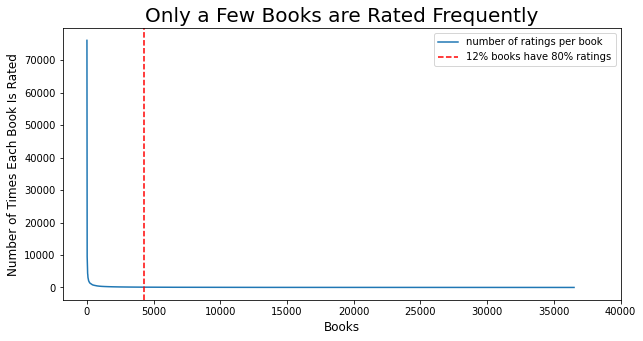

In [ ]:
# plot the number of times each book is rated
plt.figure(figsize = (10, 5))
book_num_ratings.plot(label = 'number of ratings per book')
plt.xlabel('Books', fontsize = 12)
plt.ylabel('Number of Times Each Book Is Rated', fontsize = 12)
plt.title('Only a Few Books are Rated Frequently', fontsize = 20)
plt.xticks(ticks = range(0, 40001, 5000), labels = range(0, 40001, 5000))
plt.axvline(x = 4315, color = 'r', linestyle = '--', label = '12% books have 80% ratings') # number of 12% most active users from the print statement
plt.legend()
# plt.savefig('/content/drive/MyDrive/BrainStation Capstone/book_num_ratings.png', transparent = True)
plt.show()

Before modeling, we will filter out the users and books that don't participate in rating much, in order to increase quality of prediction.

### `rating`

What's the ratings scale and the distribution?

In [ ]:
# distribution of ratings
Interactions['rating'].value_counts().sort_index()

0    1505291
1      20497
2      64084
3     237942
4     405565
5     500971
Name: rating, dtype: int64

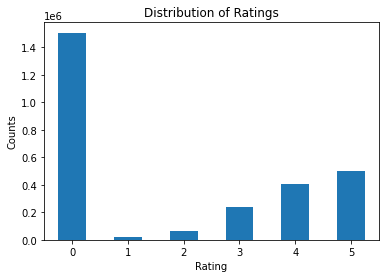

In [9]:
# plot the ratings
plt.figure()
Interactions['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Rating')
plt.xticks(rotation = 0)
plt.ylabel('Counts')
plt.title('Distribution of Ratings')
plt.show()

The majority of the ratings is `0`! Does this mean most books are terrible? Or the users didn't actually rate them and `0` is the default value?

In [ ]:
# check the rows with rating = 0
zero_ratings = Interactions[Interactions['rating'] == 0][['rating', 'is_read']]
print('Number of zero ratings:', zero_ratings.shape[0])

# check the relationship between rating = 0 and is_read
zero_ratings.groupby('is_read').count()['rating']/len(Interactions[Interactions['rating'] == 0])

Number of zero ratings: 1505291


is_read
False    0.943831
True     0.056169
Name: rating, dtype: float64

In the 1.5 million interactions where a user rates a book with 0, about 94% of them are labeled `False` for `is_read`. It's very likely that 0 is the default value for ratings.

Here we confirm with the documentations from the data source:
`'0' indicates rating score is not provided` (https://github.com/MengtingWan/goodreads/blob/master/distributions.ipynb)

Note: If this information was not available, the possible next steps could be:
* download the `Reviews` dataset available form the data source, check the content and sentiment from the reviews
* go to goodread.com to find out the scaling range

Since `0` means no rating score is provided, in the data cleaning steps, we will drop all zero ratings from our dataset. They will be treated the same way as empty values in matrix factorization.

Here's the distribution of ratings excluding zero ratings. The number of ratings ascends with the rating scale!

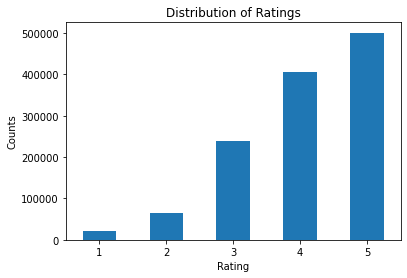

In [10]:
# plot the non-zero ratings 
plt.figure()
Interactions[Interactions['rating'] != 0]['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Rating')
plt.xticks(rotation = 0)
plt.ylabel('Counts')
plt.title('Distribution of Ratings')
plt.show()

### Others

We can also take a look at the distribution of some other variables:

Excluding empty values, 70% of the ratings are contributed by 5 most popular language codes out of 92. 

The top 5 language codes are: English, Arabic, Persian, English-US, Spanish.

In [ ]:
find_pareto_pct(df = Books[Books['language_code'] != ''], var = 'language_code', row_name = 'books', var_name = 'language codes', pct = 70);

The dataset contains 17052 books and 92 language codes in total.
70% of the books (11936) are contributed by 5% of the most active language codes (5).


In [ ]:
# top 5 language codes
Books[Books['language_code'] != '']['language_code'].value_counts()[:5]

eng      8393
ara      1608
per       924
en-US     868
spa       837
Name: language_code, dtype: int64

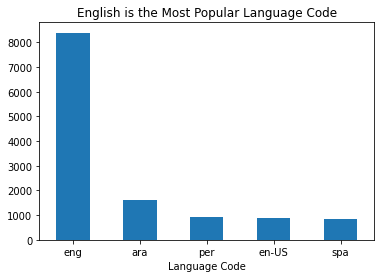

In [12]:
# plot the top 5 language codes
plt.figure()
Books[Books['language_code'] != '']['language_code'].value_counts()[:5].plot(kind = 'bar')
plt.xlabel('Language Code')
plt.xticks(rotation = 0)
plt.title('English is the Most Popular Language Code')
plt.show()

Excluding empty values, the `publisher` column also obey the Pareto Principle.

There doesn't seem to be a monopoly among publishers, as the top publishers all have similar contribution to the book list.

The most popular 5 publishers are: W. W. Norton  Company, Farrar, Straus and Giroux, Penguin Classics, Penguin Books, New Directions.

In [ ]:
find_pareto_pct(df = Books[Books['publisher'] != ''], var = 'publisher', row_name = 'books', var_name = 'publishers');

The dataset contains 30481 books and 8185 publishers in total.
80% of the books (24384) are contributed by 30% of the most active publishers (2476).


In [ ]:
# top 5 publishers
Books[Books['publisher'] != '']['publisher'].value_counts()[:5]

W. W. Norton  Company        320
Farrar, Straus and Giroux    305
Penguin Classics             302
Penguin Books                291
New Directions               261
Name: publisher, dtype: int64

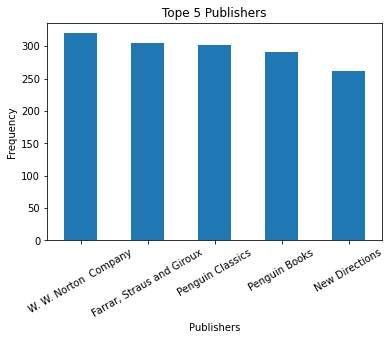

In [18]:
plt.figure()
Books[Books['publisher'] != '']['publisher'].value_counts()[:5].plot(kind = 'bar')
plt.xlabel('Publishers')
plt.ylabel('Frequency')
plt.xticks(rotation = 30)
plt.title('Tope 5 Publishers')
plt.show()

Excluding empty values, 80% of the books have less than 194 pages.

In [ ]:
find_pareto_pct(df = Books[Books['num_pages'] != ''], var = 'num_pages', row_name = 'books', var_name = 'lengths (number of pages)');

The dataset contains 29009 books and 1058 lengths (number of pages) in total.
80% of the books (23207) are contributed by 18% of the most active lengths (number of pages) (194).


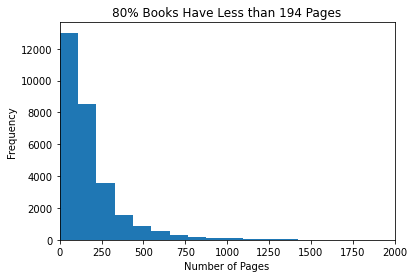

In [ ]:
# distribution of number of pages, excluding missing values
# convert datatype to int for plotting
plt.figure()
Books[Books['num_pages'] != '']['num_pages'].astype(int).plot(kind = 'hist', bins = 100)
plt.xlabel('Number of Pages')
plt.xlim(left = 0, right = 2000)
plt.title('80% Books Have Less than 194 Pages')
plt.show()

Have there been more interactions (ratings/reviews) over the years? We can count the number of reviews added by users per day from `date_added` column in `Interactions`.

In [19]:
# reformat the review date
from datetime import datetime
review_date = Interactions['date_added'].copy()
review_date = review_date.apply(lambda x: datetime.strptime(x, '%a %b %d %H:%M:%S %z %Y').strftime("%Y-%m-%d"))
review_date

0          2007-05-09
1          2007-05-09
2          2007-01-13
3          2016-04-27
4          2012-06-04
              ...    
2734345    2013-05-23
2734346    2013-04-28
2734347    2013-04-28
2734348    2013-04-21
2734349    2013-04-20
Name: date_added, Length: 2734350, dtype: object

In [20]:
# counts of reviews per day
review_counts = review_date.value_counts().sort_index()
review_counts

2001-02-13      1
2001-06-13      2
2001-10-08     18
2001-11-11      1
2002-03-12      1
             ... 
2017-10-30    126
2017-10-31    176
2017-11-01    120
2017-11-02     90
2017-11-03     92
Name: date_added, Length: 3978, dtype: int64

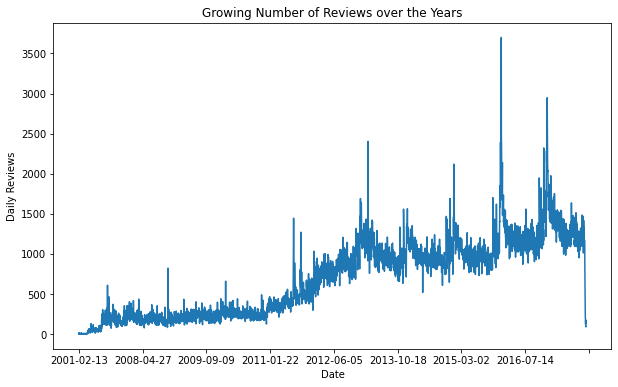

In [21]:
# plot the reviews per day over the years
plt.figure(figsize = (10, 6))
review_counts.plot()
plt.xlabel('Date')
plt.ylabel('Daily Reviews')
plt.title('Growing Number of Reviews over the Years')
plt.show()

There's an overall growth of interactions from 2001 to 2017. 

We can also see there's roughly a yearly pattern from 2013 to 2017. Let's zoom in on that.

In [ ]:
# filter the records for 2013-2017
review_counts = review_counts['2013-01-01':]
review_counts

2013-01-01    1337
2013-01-02    1386
2013-01-03    1488
2013-01-04    1399
2013-01-05    1641
              ... 
2017-10-30     126
2017-10-31     176
2017-11-01     120
2017-11-02      90
2017-11-03      92
Name: date_added, Length: 1768, dtype: int64

In [ ]:
# fill the dates between 2013-01-01 and 2017-12-31 for plotting consistency

# set the target indices with date range
idx = pd.date_range('2013-01-01', '2017-12-31')

# convert the index from strings to datetimes
review_counts.index = pd.DatetimeIndex(review_counts.index)

# fill the series with missing dates
review_counts = review_counts.reindex(idx, fill_value = 0)

review_counts

2013-01-01    1337
2013-01-02    1386
2013-01-03    1488
2013-01-04    1399
2013-01-05    1641
              ... 
2017-12-27       0
2017-12-28       0
2017-12-29       0
2017-12-30       0
2017-12-31       0
Freq: D, Name: date_added, Length: 1826, dtype: int64

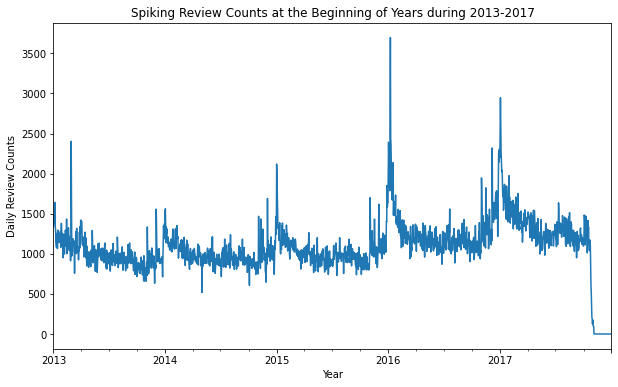

In [ ]:
# plot the daily review counts during 2013-2017
plt.figure(figsize = (10, 6))
review_counts.plot()
plt.xlabel('Year')
plt.ylabel('Daily Review Counts')
plt.title('Spiking Review Counts at the Beginning of Years during 2013-2017')
plt.show()

Looks like the number of interactions is specifically higher around the beginning of every year. Maybe that's when people have finished reading the books they received as Christmas gifts!

## Data Cleaning

### Remove columns (Feature Selection)

To build a recommender system using matrix factorization, we need the unique identifier of books and users, and the ratings. 

We will use `user_id`, `book_id`, and `rating` from `Interactions` to build our recommender system. The corresponding information like `title` and `link` from `Books` will also be included to in the list of recommended books.

In [25]:
# only keep the columns we need
Interactions = Interactions[['user_id', 'book_id', 'rating']]
Books = Books[['book_id', 'title', 'link']]

In [26]:
# convert the datatype of book_id from int to string
Interactions['book_id'] = Interactions['book_id'].astype('string')
Books['book_id'] = Books['book_id'].astype('string')

Merge these two dataframes into one:

In [27]:
# merge Interactions and Books
df = pd.merge(Interactions, 
              Books, 
              left_on = 'book_id',
              right_on = 'book_id',
              how = 'left')

In [ ]:
# examine the merged df
df.head(2)

,user_id,book_id,rating,title,link
0,8842281e1d1347389f2ab93d60773d4d,1384,4,The Odyssey,https://www.goodreads.com/book/show/1384.The_O...
1,8842281e1d1347389f2ab93d60773d4d,1376,4,The Iliad,https://www.goodreads.com/book/show/1376.The_I...


`rating` contains `int` values, ready for following model calculation.

In [ ]:
# check for data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2734350 entries, 0 to 2734349
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   book_id  string
 2   rating   int64 
 3   title    object
 4   link     object
dtypes: int64(1), object(3), string(1)
memory usage: 125.2+ MB


The average rating is 0.4, probably because not all users rate all books and the missing values are represented by 0.

In [ ]:
df.describe()

,rating
count,2.734350e+06
mean,1.824787e+00
std,2.123223e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.000000e+00
max,5.000000e+00


Excluding the zero ratings, the average rating is around 4.

In [ ]:
# exclud the zero ratings
df[df['rating'] != 0].describe()

,rating
count,1.229059e+06
mean,4.059696e+00
std,9.779034e-01
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Remove Rows (Filtering)

First, the interactions with rating `0` will be removed. It indicates that no rating score is provided, and about 95% of these interactions are labelled "not read". 

In matrix factorization, these interactions will be treated the same as empty values.

In [28]:
# filter out interactions with rating = 0
print(f'The dataset originally has {df.shape[0]} rows.')
df = df[df['rating'] != 0]
print(f'After filtering out the zero ratings, the dataset now has {df.shape[0]} rows.')

The dataset originally has 2734350 rows.
After filtering out the zero ratings, the dataset now has 1229059 rows.


For the purpose of building a more predictive recommender system, we'd also like to filter out the books that have been rated only a few times, and the users that only rated a few books.

To further shrink the size of the dataset and shorten the run time, a higher number on the conditions is chosen to filter out more interactions.

In [29]:
# filter the data 
book_min_rated = 60 # filter out books rated less than 200 times
user_min_rated = 40 # filter out users rated less than 100 books (surprisingly, there's plenty left!)

booklist = pd.DataFrame(df.groupby('book_id').count()['rating']) # column rating is the counts of ratings
userlist = pd.DataFrame(df.groupby('user_id').count()['rating']) # column rating is the counts of ratings

original_num_books = booklist.shape[0]
original_num_users = userlist.shape[0]
original_num_ratings = df.shape[0]

filtered_book_ids = booklist[booklist['rating'] >= book_min_rated].index
filtered_user_ids = userlist[userlist['rating'] >= user_min_rated].index

df = df[df['book_id'].apply(lambda x: x in filtered_book_ids)]
df = df[df['user_id'].apply(lambda x: x in filtered_user_ids)]
df.reset_index(inplace = True, drop = True)

filtered_num_books = len(filtered_book_ids)
filtered_num_users = len(filtered_user_ids)
filtered_num_ratings = df.shape[0]

print(f'The dataset originally contains {original_num_books} books, {original_num_users} users, and {original_num_ratings} rating records.')
print(f'The filtered data now has {filtered_num_books} books, {filtered_num_users} users, and {filtered_num_ratings} rating records.')

The dataset originally contains 36182 books, 267821 users, and 1229059 rating records.
The filtered data now has 2474 books, 2917 users, and 133080 rating records.


In [ ]:
df.sample(5).reset_index(drop = True)

,user_id,book_id,rating,title,link
0,06d2b1d9f173bc4a58824b138d67cc6d,46199,5,Letters to a Young Poet,https://www.goodreads.com/book/show/46199.Lett...
1,3d82d8c3b3018fa7cef1b555bca0a95f,138164,5,Selected Poems,https://www.goodreads.com/book/show/138164.Sel...
2,8129d617e084329ea4fd3503482adc17,385672,5,Collected Poems of George Oppen,https://www.goodreads.com/book/show/385672.Col...
3,e491493edfffbe27cea98ecdf884dfe4,47733,3,Love Poems,https://www.goodreads.com/book/show/47733.Love...
4,8befec84d6fe38dfaa2b5d0bae677254,138164,5,Selected Poems,https://www.goodreads.com/book/show/138164.Sel...


# Modeling

## Explain the math

### Matrix Factorization

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. 

This family of methods became widely known during the Netflix prize challenge due to its effectiveness as reported by Simon Funk in his 2006 blog post, where he shared his findings with the research community. The prediction results can be improved by assigning different regularization weights to the latent factors based on items' popularity and users' activeness.

**Mathematics factorization**:

e.g. 15 = 3 x 5

**Matrix factorization**:

matrix R (n rows x m columns) = matrix U (n rows x k columns) x matrix VT (V transposed) (k rows x m columns)

                               +-----+-----+-----+-----+-----+
                               |     |     |     |     |     |
                               +-----+-----+-----+-----+-----+
                               |     |     |     |     |     |   VT = 3x5
                               +-----+-----+-----+-----+-----+
                               |     |     |     |     |     |
                               +-----+-----+-----+-----+-----+

      +-----+-----+-----+      +-----+-----+-----+-----+-----+
      |     |     |     |      |     |     |     |     |     |
      +-----+-----+-----+      +-----+-----+-----+-----+-----+
      |     |     |     |      |     |     |     |     |     |
      +-----+-----+-----+      +-----+-----+-----+-----+-----+   R = 4x5
      |     |     |     |      |     |     |     |     |     |
      +-----+-----+-----+      +-----+-----+-----+-----+-----+
      |     |     |     |      |     |     |     |     |     |
      +-----+-----+-----+      +-----+-----+-----+-----+-----+
            U = 4x3

### SVD (Singular Value Decomposition)

There are many different ways to factor matrices, but singular value decomposition is particularly useful for making recommendations.

At a high level, SVD is an algorithm that decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where R is users's ratings matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the book "features" matrix. $U$ and $V^{T}$ are orthogonal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each book.

To get the lower rank approximation, we take these matrices and keep only the top $k$ features (latent factors), which we think of as the underlying tastes and preferences vectors.

Let's say that we have 4 users and 5 books in our dataset, but realistically, not all users rate all books. The interaction matrix R contains many empty values. 

The matrix U 4x3 is user-feature affinity matrix, and VT 3x5 is item-feature relevance matrix. Σ 3x3 is diagonal feature weight matrix. 3 here is the number of latent factors.

      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     |     |        |     |     |     |     |     |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
    Σ |     |     |     |        |     |     |     |     |     |   VT = 3x5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     |     |        |     |     |     |     |     |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+

                                   B1    B2    B3    B4    B5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     |     |    U1  |  5  |     |  4  |  2  |     |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     |     |    U2  |     |  4  |     |     |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+   R = 4x5
      |     |     |     |    U3  |  4  |     |     |  1  |  2  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     |     |    U4  |     |     |  4  |  1  |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
            U = 4x3

The model would first fill matrices U, VT and Σ with random values:

      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | 0.5 |     |     |        | 2.3 | 2.4 | 2.5 | 2.6 | 2.7 |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
    Σ |     | 0.2 |     |        | 2.8 | 2.9 | 3.0 | 3.0 | 3.0 |   VT = 3x5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     | 1.1 |        | 3.0 | 3.0 | 3.0 | 3.0 | 3.0 |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+

                                   B1    B2    B3    B4    B5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | 1.1 | 1.2 | 1.3 |    U1  |  5  |     |  4  |  2  |     |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | 1.4 | 1.5 | 1.6 |    U2  |     |  4  |     |     |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+   R = 4x5
      | 1.7 | 1.8 | 1.9 |    U3  |  4  |     |     |  1  |  2  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | 2.0 | 2.1 | 2.2 |    U4  |     |     |  4  |  1  |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
            U = 4x3
          
Then, it calculates each position in matrix R using the values in U, V and Σ. 

For example, the value in R between U1 and B1 can be calculated from the dot product of U and Σ and VT:

Dot product of Σ and VT:

       +---------+---------+-----+-----+-----+
       | 0.5x2.3 | 0.5x2.4 | ... | ... | ... |
       +---------+---------+-----+-----+-----+
       | 0.2x2.8 | 0.2x2.9 | ... | ... | ... | 
       +---------+---------+-----+-----+-----+
       | 1.1x3.0 | 1.1x3.0 | ... | ... | ... |
       +---------+---------+-----+-----+-----+

       +---------+---------+-----+-----+-----+
       |   1.15  |   1.20  | ... | ... | ... |
       +---------+---------+-----+-----+-----+
       |   0.56  |   0.58  | ... | ... | ... | 
       +---------+---------+-----+-----+-----+
       |   3.30  |   3.30  | ... | ... | ... |
       +---------+---------+-----+-----+-----+

Dot product of U and the matrix above is R. The value in cell U1_B1 can be calculated as:

1.1 * 1.15 + 1.2 * 0.56 + 1.3 * 3.3 = 6.227

Since this prediction is higher than the actual value of U1_B1 (5), we will slightly descrease the values in the cells we just used for calculation: the diagonal values in Σ, the first column of VT, and the first row of U.

If the predicted value is lower than the actual value, we will slightly increase the values in those cells.

By calculating all the positions in R that has actual value, we can adjust the values in U, VT and Σ repetitively to minimize the errors. This process is called **Gradient Descent**.

After this process, we will have the optimal U and V, with the minimal error between our calculation and the actual values in R.

      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | ... |     |     |        | ... | ... | ... | ... | ... |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
    Σ |     | ... |     |        | ... | ... | ... | ... | ... |   VT = 3x5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      |     |     | ... |        | ... | ... | ... | ... | ... |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+

                                   B1    B2    B3    B4    B5
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | ... | ... | ... |    U1  |  5  |     |  4  |  2  |     |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | ... | ... | ... |    U2  |     |  4  |     |     |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+   R = 4x5
      | ... | ... | ... |    U3  |  4  |     |     |  1  |  2  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
      | ... | ... | ... |    U4  |     |     |  4  |  1  |  5  |
      +-----+-----+-----+        +-----+-----+-----+-----+-----+
            U = 4x3

With the optimal U, VT and Σ, we can do a dot product and generate predictions for all the empty values in R! Those would be how we predict the users would rate certain books, and we can recommend the books that we think they will rate highly to them!

### RMSE vs MAE

When comparing the calculated value (prediction score) and the actual value (true score), there are two metrics commonly used.

**Root mean square error** (RMSE):

$$\sqrt{\frac{1}{n}\sum_{ij}(R_{ij}-\hat R_{ij})^2}$$

**Mean absolute error** (MAE) 


$$\frac{1}{n}\sum_{ij}|R_{ij}-\hat R_{ij}|$$

To understand the difference between them, let's see an example. 

Say we have 3 rating records, and we also made predictions for each of them.

In [ ]:
# example 
sample = pd.DataFrame()
sample['Actual Value'] = [5, 2, 4]
sample['Predicted Value'] = [3, 1, 5]
sample

,Actual Value,Predicted Value
0,5,3
1,2,1
2,4,5


To calculate RMSE, we'll first calculate the square error:

In [ ]:
# square error
sample['SE'] = (sample['Actual Value'] - sample['Predicted Value']) ** 2
display(sample)

# mean square error
print('MSE (4 + 1 + 1) / 3 =', sample['SE'].mean())

# root mean square error:
print('RMSE is the root of MSE:', np.sqrt(sample['SE'].mean()).round(2))

,Actual Value,Predicted Value,SE
0,5,3,4
1,2,1,1
2,4,5,1


MSE (4 + 1 + 1) / 3 = 2.0
RMSE is the root of MSE: 1.41


To calculate MAE, we'll first calculate the absolute error:

In [ ]:
# absolute error
sample['AE'] = abs(sample['Actual Value'] - sample['Predicted Value'])
display(sample)

# mean absolute error
print('MAE (2 + 1 + 1) / 3 =', round(sample['AE'].mean(), 2))

,Actual Value,Predicted Value,SE,AE
0,5,3,4,2
1,2,1,1,1
2,4,5,1,1


MAE (2 + 1 + 1) / 3 = 1.33


As we can see from the example, RMSE is always larger than or equal to MAE. The greater the difference between them, the greater the variance in the individual errors in the sample. If the RMSE = MAE, then all the errors are of the same magnitude.

RMSE gives a relatively high weight to larger errors. This means RMSE should be used over MAE when large errors are especially undesired.

## Build the model

#### Train and Test on Known Values

In [22]:
# install surprise package
!pip install surprise

     |████████████████████████████████| 11.8 MB 49 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617757 sha256=3a8738786b4c6df27798364124bbe9621d02ffae003132d9cd5edb2c6b7ccf1b
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [23]:
# import the functions needed
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [30]:
# convert the data into the surprise dataset format
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader = reader)

In [33]:
# split train and test set, with test set size as 20%
trainset, testset = train_test_split(data, test_size=0.2, random_state = 0)

In [34]:
# initiate the model
algo = SVD()

# train the model on the train set, and predict ratings for the test set
algo.fit(trainset)
predictions = algo.test(testset)

In [35]:
# see the predictions of the test set in a dataframe
pred_df = pd.DataFrame(predictions)
pred_df.head()

,uid,iid,r_ui,est,details
0,3496b6c3b52e81078aa5bddb5b542846,10910023,5.0,3.923806,{'was_impossible': False}
1,15fbcee51d8ab709f3d3902385135afd,23296297,5.0,4.396339,{'was_impossible': False}
2,cf1dc5779d74aab50f4ef944c4a4de34,71654,4.0,3.514221,{'was_impossible': False}
3,2dfa7627f1c9330576360b4bfb24f6f6,6387626,5.0,4.105496,{'was_impossible': False}
4,b45650498882a0b4697c02cbc4f798d2,270903,4.0,4.356175,{'was_impossible': False}


In the prediction, `uid` is the `user_id`, `iid` is the `book_id`, `r_ui` is the known value from the original data, and `est` is the predicted rating.

To evaluate the model, the RMSE and MAE are calculated.

For the test set, RMSE is 0.81 and MAE is 0.63. 

In [36]:
# RMSE of the test set
accuracy.rmse(predictions);

# MAE of the test set
accuracy.mae(predictions);

RMSE: 0.8124
MAE:  0.6280


##### Base rate

Are these values impressive enough? We can compare them with the base rate: predicting by the average or mode of ratings.

Since `surprise` has converted the data into it's special black-box format, we need to do this manually.

In [37]:
# put testset into a df
testset_df = pd.DataFrame(testset, columns = ['user_id', 'book_id', 'rating'])
print(f'Testset has {testset_df.shape[0]} rows.')

Testset has 26616 rows.


In [38]:
# find the rating records from the trainset for users in the testset
# since the trainset is now in a special surprise format, it can't be operated directly
# the traset will be filtered out from the original data

fullset = df[['user_id', 'book_id', 'rating']]
keys = list(testset_df.columns.values)
i1 = fullset.set_index(keys).index
i2 = testset_df.set_index(keys).index
trainset_df = fullset[~i1.isin(i2)]
print(f'Trainset has {trainset_df.shape[0]} rows.')

Trainset has 106464 rows.


In [ ]:
# calculate the rating average and mode for each user
base_rate = trainset_df.groupby("user_id")['rating'].agg([np.mean, lambda x:x.value_counts().index[0]])
base_rate.rename(columns = {'mean': 'Average', '<lambda_0>': 'Mode'}, inplace = True)
base_rate = base_rate.rename_axis('user_id').reset_index()
base_rate.head()

,user_id,Average,Mode
0,0017507d4413a03fbfa5848972658206,3.324324,4
1,002ebed2a6bd926cbf41313ebd8cfaba,4.219512,5
2,005f35d2daeb6f48bdb13fbd8c6a2522,4.062500,5
3,006c959ba748bfa5f48fa5fa989322c6,4.933333,5
4,0071b2ff88ae4de512e97640a7f49698,3.882353,4


In [ ]:
# join the average and mode of each user to the testset
testset_base_rate = pd.merge(testset_df, base_rate, left_on = 'user_id', right_on = 'user_id', how = 'left')
testset_base_rate

,user_id,book_id,rating,Average,Mode
0,3496b6c3b52e81078aa5bddb5b542846,10910023,5.0,4.097561,5
1,15fbcee51d8ab709f3d3902385135afd,23296297,5.0,4.170732,4
2,cf1dc5779d74aab50f4ef944c4a4de34,71654,4.0,3.500000,4
3,2dfa7627f1c9330576360b4bfb24f6f6,6387626,5.0,4.303030,5
4,b45650498882a0b4697c02cbc4f798d2,270903,4.0,4.270270,4
...,...,...,...,...,...
26611,a9fc156001420b0d86ab40c25dcf5a45,223394,4.0,4.078652,5
26612,058d86a24d8ed0516eca00476ae21a75,7824768,1.0,3.260163,4
26613,7223a2518662840ed8c51c0efcd04e8f,6100917,4.0,3.880000,4
26614,084fb44abaabe412992ef746073fa7fc,20413,4.0,3.903226,4


In [ ]:
# import the functions calculating RMSE & MAE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# calculate the base rate
print('When predict by the historical average rating of each user:')
print('RMSE', mean_squared_error(y_true = testset_base_rate['rating'], y_pred = testset_base_rate['Average'], squared = False).round(4))
print('MAE', mean_absolute_error(y_true = testset_base_rate['rating'], y_pred = testset_base_rate['Average']).round(4))
print('\n')
print('When predict by the mode of historical ratings of each user:')
print('RMSE', mean_squared_error(y_true = testset_base_rate['rating'], y_pred = testset_base_rate['Mode'], squared = False).round(4))
print('MAE', mean_absolute_error(y_true = testset_base_rate['rating'], y_pred = testset_base_rate['Mode']).round(4))

When predict by the historical average rating of each user:
RMSE 0.8419
MAE 0.6472


When predict by the mode of historical ratings of each user:
RMSE 1.0066
MAE 0.6363


In [ ]:
# recall the loss of the model predictions

# RMSE of the test set
accuracy.rmse(predictions);

# MAE of the test set
accuracy.mae(predictions);

RMSE: 0.8119
MAE:  0.6284


The prediction model performs better than the base rate, with RMSE 0.03-0.19 lower and MAE 0.01-0.02 lower.

We will optimize these errors by hyperparameter tuning.

### Hyperparameter Tuning

#### Single Parameter - Visualization

When working with `sklearn`, we used to first split the data into train and test set, and then use the train set to fit and optimize the model through cross validation. However, `surprise` is a package specifically designed for recommender systems, which are usually evaluated in a different way.

Datasets in `surprise` have the format `surprise.dataset.DatasetAutoFolds`, which can be fit into `surprise.model_selection.cross_validate`.

However, `surprise.model_selection.train_test_split` converts the trainset into another format, `surprise.trainset.Trainset`, which can no longer be fit into the cross validation function, for hyperparameter tuning purpose.

If we split the sets using `sklearn.mode_selection.train_test_split` or manully, they will be in `surprise.dataset.DatasetAutoFolds` format, and can't be used for fitting the model or making predictions.

Therefore, we will first split the data into train and test set, to see the evaluation (RMSE/MAE) under the initial model. Then, we will use the entire dataset for cross validation, to optimize the hyperparameters. At last, a full train set will be built based on the entire known dataset. A full test set will also be generated representing all the empty elements in the utility matrix, so we can make the prediction from it.

In [ ]:
# datatype of the entire dataset
type(data)

surprise.dataset.DatasetAutoFolds

In [ ]:
# datatype of the splitted trainset
type(trainset)

surprise.trainset.Trainset

In [ ]:
# trainset datatype can't be used for cross validation
try:
  cross_validate(SVD(), trainset)
except:
  print("AttributeError: 'Trainset' object has no attribute 'raw_ratings'")

AttributeError: 'Trainset' object has no attribute 'raw_ratings'


In [ ]:
# data datatype can't be used for fitting the model (as a trainset)
algo = SVD()
try:
  algo.fit(data)
except:
  print("DatasetAutoFolds' object has no attribute 'global_mean")

DatasetAutoFolds' object has no attribute 'global_mean


For `SVD()`, we can search for the optimal `n_factors`, the number of latent factors.

In [39]:
# generates a list of loss (RMSE by default) through a series of n_factors

def loss_by_factors(data, algorithm, loss_type = 'RMSE', min_n_factors = 1, max_n_factors = 50, step_n_factors = 1, list_n_factors = None, cv = 5):

  '''
  generates a list of loss (RMSE by default) through a series of n_factors

  Parameters
  ---
  algorithm: a surprise matrix factorization algorithm, a function
  data: a surprise dataset
  loss_type: the type of loss to be calculated, a string, default = 'RMSE'
  min_n_factors: the minimum n_factors to be calculated for loss, an integer, default = 1
  max_n_factors: the maximum n_factors to be calculated for loss (inclusive), an integer, default = 51
  step_n_factors: the incrementation, an integer, default = 1
  list_n_factors: a list of specified n_factors, a list of integers, default = None
  cv: number of folds, an integer, default = 5
  
  If list_n_factors is not None, the function will calculate based on the values in list_n_factors
  If list_n_factors is None, the function will calculate based on the values of min_n_factors, max_n_factors, step_n_factors

  
  Returns
  ---
  loss_list: a list of calculated loss, a list of floats

  Example
  ---
  >>>> loss_by_factors(algorithm = SVD, data, loss_type = 'RMSE', list_n_factors = [1, 2, 3])
  [0.5, 0.7, 0.22]
  '''

  # assert the datatype of inputs
  # algorithm and data will have build-in error messages if the format is incorrect
  assert isinstance(loss_type, str), 'loss_type must be a string'
  assert (isinstance(min_n_factors, int)) & (min_n_factors > 0), 'min_n_factors must be a positive integer'
  assert (isinstance(max_n_factors, int)) & (max_n_factors > min_n_factors), 'max_n_factors must be an integer larger than min_n_factors'
  assert (isinstance(step_n_factors, int)) & (step_n_factors > 0), 'step_n_factors must be a positive integer'

  if list_n_factors != None:
    assert isinstance(list_n_factors, list), 'list_n_factors must be a list or None'
    assert all((isinstance(item, int)) & (item > 0) for item in list_n_factors), 'list_n_factors must only contain positive integers'

  assert (isinstance(cv, int) & (cv > 0)), 'cv must be a positive integer'

  
  # create an empty list for the loss arcoss a series of factors
  loss_list = []
  result_column_name = 'test_' + loss_type.lower()

  # determine the range of the loop by input parameters
  if list_n_factors == None:
    n_factors_range = range(min_n_factors, max_n_factors + 1, step_n_factors) # max_n_factors is inclusive
  else:
    n_factors_range = list_n_factors

  # print an update
  print('Generating the ' + loss_type + ' for n_factors in:')
  print(n_factors_range)

  # loop through the range of n_factors
  for n in n_factors_range:
    
    # print an update
    print(f'Calculating n_factors = {n} ...')
    
    # initiate the algorithm
    algo = algorithm(n_factors = n)
    
    # cross validate and take the mean of loss
    loss = cross_validate(algo, data, measures = [loss_type], cv = cv)[result_column_name].mean()
    loss_list.append(loss)

  print('\n')
  
  return loss_list

In [40]:
RMSE_list = loss_by_factors(data, algorithm = SVD, loss_type = 'RMSE')
MAE_list = loss_by_factors(data, algorithm = SVD, loss_type = 'MAE')

Generating the RMSE for n_factors in:
range(1, 51)
Calculating n_factors = 1 ...
Calculating n_factors = 2 ...
Calculating n_factors = 3 ...
Calculating n_factors = 4 ...
Calculating n_factors = 5 ...
Calculating n_factors = 6 ...
Calculating n_factors = 7 ...
Calculating n_factors = 8 ...
Calculating n_factors = 9 ...
Calculating n_factors = 10 ...
Calculating n_factors = 11 ...
Calculating n_factors = 12 ...
Calculating n_factors = 13 ...
Calculating n_factors = 14 ...
Calculating n_factors = 15 ...
Calculating n_factors = 16 ...
Calculating n_factors = 17 ...
Calculating n_factors = 18 ...
Calculating n_factors = 19 ...
Calculating n_factors = 20 ...
Calculating n_factors = 21 ...
Calculating n_factors = 22 ...
Calculating n_factors = 23 ...
Calculating n_factors = 24 ...
Calculating n_factors = 25 ...
Calculating n_factors = 26 ...
Calculating n_factors = 27 ...
Calculating n_factors = 28 ...
Calculating n_factors = 29 ...
Calculating n_factors = 30 ...
Calculating n_factors = 31 .

After generating a list of RMSE and MAE across different `n_factors`, we can plot these values to visualize the best option.

In [41]:
# plot the mean RMSE and MAE through a series of n_factors

def plot_losses(losses, labels):
  '''
  Parameters
  ---
  losses: a list of loss lists to plot iterately
  labels: a list of names of the items in losses, in the same order e.g. ['RMSE', 'MAE']
  '''

  # number of items in losses
  n = len(losses)

  # set figure size based on n
  plt.figure(figsize=(12, 4 * n))

  # loop through items in losses
  for i in range(n):

    # plot the loss
    plt.subplot(n, 1, i + 1)
    plt.plot(losses[i])
    plt.ylabel(labels[i])

    # label the minimum value
    plt.axvline(np.argmin(losses[i]), color = "r")

    # add the title at the top
    if i == 0:
      plt.title('Looking for the optimal n_factors')

    # add the x label at the bottom
    if i == n - 1:
      plt.xlabel('n_factors in SVD()')
  plt.show()

  print('The lower the loss, the better the model.')

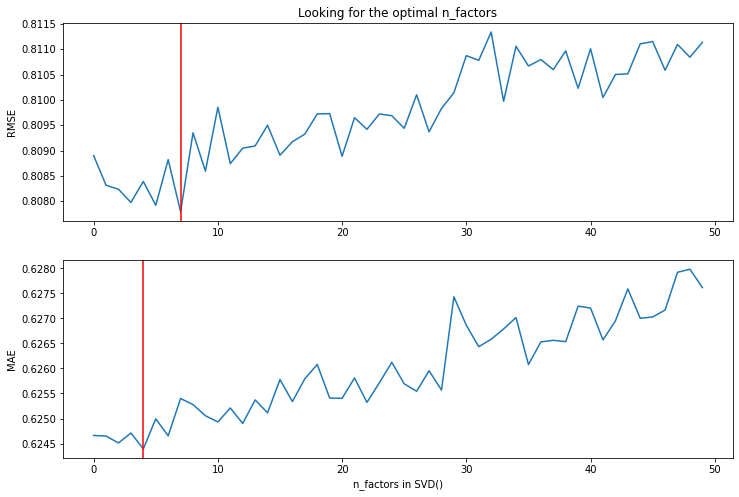

The lower the loss, the better the model.


In [42]:
plot_losses([RMSE_list, MAE_list], ['RMSE', 'MAE'])

From the visualization, we can see the model has the lowest `RMSE` when `n_factors = 7`, and the lowest `MAE` when `n_factors = 4`.

Note: each value plotted is the mean value from a 5-fold cross validation. The minimum value could change slightly due to the randomness of cross validation.

#### Multiple parameters - Grid Search

If we want to take one more step and optimize more hyperparameters, we can use a grid search.

In [46]:
# write the grid search parameters
param_grid = {'n_factors': range(3, 10), # default 100, range referenced from previous visualization
              'n_epochs': [10, 15, 20, 25, 30, 40, 50], # default 20
              'lr_all': [0.002, 0.005, 0.008]} # default 0.005

# initiate the grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1, joblib_verbose = 10)

# fit the grid search 
gs.fit(data)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10

In [47]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8112422912006326
{'n_factors': 3, 'n_epochs': 50, 'lr_all': 0.002}


In [48]:
# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

0.6256204225890918
{'n_factors': 3, 'n_epochs': 40, 'lr_all': 0.005}


Although these scores are not much different from our initial model, it should be noted that the initial model is fitted on the training set, which contains about 80% of the data. This model instead is trained on all the known value.

We'll take the combination of hyperparameters from the best MAE score to construct our optimal model.

### Optimal Model

With the best hyperparameters, we can now rebuild the model and make predictions for all the empty elements in the utility matrix.

In [49]:
# builds the training set from the entire data set, instead of splitting it
full_trainset = data.build_full_trainset()

# re-model with the optimal hyperparameters to predict values for empty elements
best_svd = SVD(n_factors = 3, n_epochs = 40, lr_all = 0.005)
best_svd.fit(full_trainset)

# returns a list of ratings (testset) that are not in the trainset or in the entire utility matrix
full_testset = full_trainset.build_anti_testset()

predictions = best_svd.test(full_testset)

In [50]:
# output the df for the interactive app

# pd.DataFrame(predictions)[['uid', 'iid', 'est']].to_csv('/content/drive/MyDrive/BrainStation Capstone/pred.csv')
# pd.DataFrame(Books).to_csv('/content/drive/MyDrive/BrainStation Capstone/Books.csv')
# pd.DataFrame(df).to_csv('/content/drive/MyDrive/BrainStation Capstone/ratings.csv')

With the `predictions` matrix, we can write a function to generate a list of recommended books for a given (existing) user.

In [51]:
# write a function to return a list of recommended books

def get_recommendations(predictions, user_id, book_df, ratings_df, num_recommendations = 10):

  '''
  Parameters
  ---
  predictions: a list of predictions returned from best_svd.test(testset)
  user_id: a user id, a string
  book_df: all unique books with book id, title and link, a dataframe 
  ratings_df: the existing rating records, a dataframe
  num_recommendations: the number of recommended books to return, a positive integer, default = 10

  Output:
  ---
  for new users:
  print statement and table display
  most_popular_books: books with the highest rating sum, a dataframe, number of rows = num_recommendations

  for existing users:
  print statement and table display
  hist_ratings: highest historical ratings of this user, a dataframe, number of rows = num_recommendations
  recommendations: the most recommended books for this user, a dataframe, number of rows = num_recommendations

  Example
  ---
  >>>> get_recommendations(predictions, user_id = '123abc', book_df, ratings_df, num_recommendations = 2)

  You have rated highly for these books:
  +---------+--------+---------+-----------------+
  | book_id | rating |  title  |      link       |
  +---------+--------+---------+-----------------+
  |    1    |    5   | Sample1 | www.sample1.com |
  |    2    |    5   | Sample2 | www.sample2.com |
  +---------+--------+---------+-----------------+

  We think you might like these books:
  +---------+------------------+---------+-----------------+
  | book_id | predicted rating |  title  |      link       |
  +---------+------------------+---------+-----------------+
  |    3    |       5.1        | Sample3 | www.sample3.com |
  |    4    |       4.9        | Sample4 | www.sample4.com |
  +---------+------------------+---------+-----------------+

  Note
  ---
  The `Predicted Rating` column in `recommendations` dataframe is shown for developing purpose
  When interacting with actual users, it should not be shown
  '''   

  # if the user_id doesn't exist in the database, return a list of the most popular books

  # a list of all existing users
  all_users = ratings_df['user_id'].unique()

  if user_id not in all_users:

    # sort the books by sum of ratings
    most_popular_books = ratings_df.groupby('book_id').sum('rating').sort_values('rating', ascending = False).head(num_recommendations)

    # merge the most popular books with the titles and links
    most_popular_books_list = pd.merge(most_popular_books, book_df, left_on = 'book_id', 
                                       right_on = 'book_id', how = 'left').drop('rating', axis = 1)

    # display and return    
    print('You don\'t have rating records in our database. Here are some very popular books you might like:')
    display(most_popular_books_list)
    return most_popular_books_list

  # ---------------------------------
  # ---------------------------------
  
  # if the user_id exists in the database, return a list of books rated the highest by this user, and a list of recommended books

  # part 1: get hist_ratings

  # get all rating records for the given user
  hist_user = ratings_df[ratings_df['user_id'] == user_id]

  # total number of historical ratings from this user
  num_rated = hist_user.shape[0]

  # sort the records by ratings and only take the top ones (row number: num_recommendations)
  hist_top = hist_user.sort_values('rating', ascending = False).head(num_recommendations)

  # if this user has rated less books than num_recommendations, only return the books rated
  hist_top = hist_top[hist_top['rating'] != 0]

  # merge hist_top with book_df to get titles and links
  hist_ratings = pd.merge(hist_top[['book_id', 'rating']], book_df[['title', 'link', 'book_id']], 
                          left_on = 'book_id', right_on = 'book_id', how = 'left')

  # ---------------------------------

  # part 2: get recommendations

  # put predictions (returned from best_svd.test(testset)) to a dataframe
  predictions_df = pd.DataFrame(predictions)

  # select the predictions only for the given user
  predictions_user = predictions_df[predictions_df['uid'] == user_id]

  # sort the predictions and select the top n
  top_predictions = predictions_user.sort_values(['est'], ascending = False).head(num_recommendations)

  # merge top_predictions with book_df to get titles and links
  recommendations = pd.merge(top_predictions[['iid', 'est']], book_df[['title', 'link', 'book_id']], 
                             left_on = 'iid', right_on = 'book_id', how = 'left')
  
  # clean up column names
  recommendations.drop('book_id', axis = 1, inplace = True)
  recommendations.rename(columns = {'est': 'predicted rating',
                                    'iid': 'book_id'}, inplace = True)
  
  # round predicted ratings to 1 decimal place
  recommendations['predicted rating'] = recommendations['predicted rating'].apply(lambda x: round(x, 1))
    
  # display two tables
  print(f'You have rated {num_rated} books in total. The more books you rate, the better recommendations we can offer!')
  print('\n')

  print('You have rated highly for these books:')
  display(hist_ratings)
  print('\n')

  print('We think you might like these books:')
  display(recommendations)

  # return two dataframes for potential further processing
  return hist_ratings, recommendations

# Evaluate the Model

## Test Runs for Existing Users

Let's test our recommender system on some existing users!

This user tends to rate highly. The predicted ratings therefore spike too!

In [52]:
get_recommendations(predictions, user_id = '35256a4e933aba8390cfd4dfd9573ada', book_df = Books, ratings_df = df, num_recommendations = 5);

You have rated 114 books in total. The more books you rate, the better recommendations we can offer!


You have rated highly for these books:


,book_id,rating,title,link
0,46199,5,Letters to a Young Poet,https://www.goodreads.com/book/show/46199.Lett...
1,75506,5,Collected Poetry & Prose,https://www.goodreads.com/book/show/75506.Coll...
2,16802,5,The Complete Poetry,https://www.goodreads.com/book/show/16802.The_...
3,59005,5,The Selected Levis,https://www.goodreads.com/book/show/59005.The_...
4,1258536,5,Poems of Paul Celan,https://www.goodreads.com/book/show/1258536.Po...




We think you might like these books:


,book_id,predicted rating,title,link
0,625802,5.0,Dickinson: Poems,https://www.goodreads.com/book/show/625802.Dic...
1,11403945,5.0,مجموعة شعرية لأحمد مطر,https://www.goodreads.com/book/show/11403945
2,330135,5.0,The Collected Works of Oscar Wilde,https://www.goodreads.com/book/show/330135.The...
3,1383,5.0,The Odyssey,https://www.goodreads.com/book/show/1383.The_O...
4,428557,5.0,The Yale Shakespeare Complete Works,https://www.goodreads.com/book/show/428557.The...


This user is not very generous with perfect rating. The predicted ratings are correspondingly low, too.

Also, looks like this user enjoys reading in Persian (according to our project specialist). Glad to see most of the recommendations are in this language, too!

Persian books on Goodreads: https://www.goodreads.com/shelf/show/persian

In [53]:
get_recommendations(predictions, user_id = '06e8d2ac230f524778cd9c7d04111597', book_df = Books, ratings_df = df, num_recommendations = 5);

You have rated 321 books in total. The more books you rate, the better recommendations we can offer!


You have rated highly for these books:


,book_id,rating,title,link
0,246056,4,The Garden of The Prophet,https://www.goodreads.com/book/show/246056.The...
1,112204,4,The Complete Poems of Emily Dickinson,https://www.goodreads.com/book/show/112204.The...
2,11297902,4,قبور واسعة,https://www.goodreads.com/book/show/11297902
3,10162295,4,مشوار لحد الحيطة,https://www.goodreads.com/book/show/10162295
4,6378802,4,الشوقيات,https://www.goodreads.com/book/show/6378802




We think you might like these books:


,book_id,predicted rating,title,link
0,1559717,4.0,شاهنامه فردوسی,https://www.goodreads.com/book/show/1559717._
1,230231,4.0,ديوان حافظ,https://www.goodreads.com/book/show/230231._
2,20660824,3.9,Brown Girl Dreaming,https://www.goodreads.com/book/show/20660824-b...
3,1499647,3.9,گزیده‌ی غزلیات شمس,https://www.goodreads.com/book/show/1499647._
4,187434,3.9,Hamlet: Prince of Denmark,https://www.goodreads.com/book/show/187434.Hamlet


This user has only rated 2 books! Less than `num_recommendations` given.

Note:

In preprocessing, users who have rated less than 40 books are removed. However, since we also removed books that have been rated for less than 60 time, it could happen that this user has rated 42 books in total, and 40 of them are very unpopular with very few ratings and therefore removed. The filtered data ends up with only 2 rating records from this user.

In [54]:
get_recommendations(predictions, user_id = 'bbefce9424819f90fb3d1f1ec5d28a74', book_df = Books, ratings_df = df, num_recommendations = 5);

You have rated 2 books in total. The more books you rate, the better recommendations we can offer!


You have rated highly for these books:


,book_id,rating,title,link
0,70884,5,The Last Night of the Earth Poems,https://www.goodreads.com/book/show/70884.The_...
1,47730,5,The Complete Poems,https://www.goodreads.com/book/show/47730.The_...




We think you might like these books:


,book_id,predicted rating,title,link
0,11380377,5.0,كلمات سبارتكوس الأخيرة,https://www.goodreads.com/book/show/11380377
1,9748346,5.0,الأعمال الكاملة,https://www.goodreads.com/book/show/9748346
2,187434,5.0,Hamlet: Prince of Denmark,https://www.goodreads.com/book/show/187434.Hamlet
3,1436,5.0,"Hamlet: An Authoritative Text, Intellectual Ba...",https://www.goodreads.com/book/show/1436.Hamlet
4,6348484,5.0,ديوان المتنبي,https://www.goodreads.com/book/show/6348484


## Test Run for New User

One typical problem caused by the data sparsity in SVD-based Collaborative Filtering is the **cold start problem**. As collaborative filtering methods recommend items based on users’ past preferences, new users will need to rate a sufficient number of items to enable the system to capture their preferences accurately, and thus provides reliable recommendations. Similarly, new items also have the same problem.

In our recommender system, when a new user wants some books recommended, a list of the most popular books will be returned.

In [55]:
get_recommendations(predictions, user_id = 'new_user_20210718', book_df = Books, ratings_df = df, num_recommendations = 5);

You don't have rating records in our database. Here are some very popular books you might like:


,book_id,title,link
0,1420,Hamlet,https://www.goodreads.com/book/show/1420.Hamlet
1,1381,The Odyssey,https://www.goodreads.com/book/show/1381.The_O...
2,30119,Where the Sidewalk Ends,https://www.goodreads.com/book/show/30119.Wher...
3,112204,The Complete Poems of Emily Dickinson,https://www.goodreads.com/book/show/112204.The...
4,1371,The Iliad,https://www.goodreads.com/book/show/1371.The_I...


## Other Evaluations

From cross validation in grid search, we have found the lowest MAE score 0.6259 to build the optimal model.

For the full test set (the unknown values from original dataset), we can also generate the RMSE and MAE. Here these losses are calculated against the average rating across the entire dataset.

In [56]:
# RMSE of the full test set
accuracy.rmse(predictions);

# MAE of the full test set
accuracy.mae(predictions);

RMSE: 0.5674
MAE:  0.4498


Another ranking-based metric is the Fraction of Concordant Pairs (FCP).

Suppose a user has rated n products, then there are n*(n-1)/2 unique pairs of ratings. If book A receives a higher rating than book B from a user and the model predicts the same, A and B are a concordant pair, otherwise a discordant pair. 

FCP is simply the fraction of concordant pairs among all the pairs (sum over all users), with best score 1 and worst score 0.

In [ ]:
# FCP - Fraction of Concordant Pairs, the fraction of pairs whose relative ranking order is correct
accuracy.fcp(predictions, verbose = True)

The main evaluation of a recommender system is eventually done by tracking the usage.

The most important aspect is how many interactions do the recommendations prompt users to perform. Some common metrics include Hit Rate (HR), Average Reciprocal Hit Rate (ARHR), Cumulative Hit Rate (cHR), Rating Hit Rate (rHR).

Other evaluation metrics:

* Coverage - Measures the ability of the system to recommend long-tail items

* Diversity - Measures of how broad or variety of items our Recommender System is putting in front of people

* Novelty - Balance between unfamilarity and popularity

* Churn - How often do recommendations change with new ratings

* Responsiveness - How quickly does new user behavior influence recommendations

# Conclusion

This project built a book recommender system based on rating records from www.goodreads.com in the poetry genre using matrix factorization. It can make predictions on all users for all books in the dataset, and recommend a list of popular books for new users. The SVD model and functions can be grouped into a pipeline and used on other rating data.

To improve on this recommender system and user experience, the next steps are:

* build a hybrid system to enhance recommendations, including demographic filtering, content-based filtering (NLP), ...
* build an interactive user interface, where users can input their user id and the system will return a list of recommendations

# Additional Reference


1. Collaborative Filtering: Matrix Factorization Recommender System

  https://www.jiristodulka.com/post/recsys_cf/

2. Collaborative Filtering using Deep Neural Networks (in Tensorflow)

  https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1

3. Matrix factorization (recommender systems)

  https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)

4. Matrix Factorization for Recommendations in Python

  https://github.com/beckernick/matrix_factorization_recommenders/blob/master/matrix_factorization_recommender.ipynb

5. How does Netflix recommend movies? Matrix Factorization

  https://www.youtube.com/watch?v=ZspR5PZemcs

6. Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)

  http://www.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm

7. How To Run Recommender Systems In Python

  https://predictivehacks.com/how-to-run-recommender-systems-in-python/

8. Pareto Principle

  https://www.investopedia.com/terms/p/paretoprinciple.asp

9. Recommender Systems with Python — Part III: Collaborative Filtering (Singular Value Decomposition)

  https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

10. Simple Content-based Recommenders

  https://www.kaggle.com/liyenhsu/simple-content-based-recommenders